In [1]:
import pandas as pd
import warnings
warnings.filterwarnings('ignore')
import numpy as np
import seaborn as sns
import matplotlib
from sklearn.preprocessing import StandardScaler,MinMaxScaler
import matplotlib.pyplot as plt
from scipy.stats import skew
from scipy.stats.stats import pearsonr

%config InlineBackend.figure_format = 'png'
%matplotlib inline

In [2]:
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')
iD = test['Id']

In [3]:
train.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [4]:
all_data = pd.concat((train.loc[:,'MSSubClass':'SaleCondition'],
                     test.loc[:,'MSSubClass':'SaleCondition']))

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f7a2c09e358>,
      dtype=object)

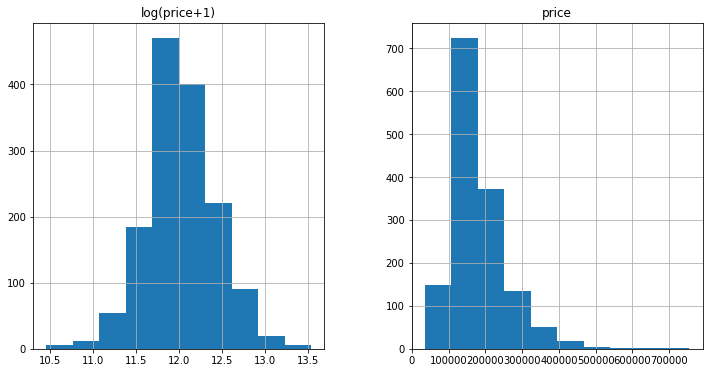

In [5]:
matplotlib.rcParams['figure.figsize'] = (12.,6.)
prices = pd.DataFrame({'price':train['SalePrice'],'log(price+1)':np.log1p(train['SalePrice'])})
prices.hist()

In [6]:
# log transform the y vector = the target
train['SalePrice'] = np.log1p(train['SalePrice'])

# log transform skewed numeric features
numeric_feats = all_data.dtypes[all_data.dtypes!='object'].index
skewed_feats = train[numeric_feats].apply(lambda x: skew(x.dropna()))
skewed_feats = skewed_feats[skewed_feats>0.7]
skewed_feats = skewed_feats.index

all_data[skewed_feats] = np.log1p(all_data[skewed_feats])

In [7]:
all_data = pd.get_dummies(all_data)
all_data.head()

,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,...,SaleType_ConLw,SaleType_New,SaleType_Oth,SaleType_WD,SaleCondition_Abnorml,SaleCondition_AdjLand,SaleCondition_Alloca,SaleCondition_Family,SaleCondition_Normal,SaleCondition_Partial
0,4.110874,4.189655,9.042040,7,5,2003,2003,5.283204,6.561031,0.0,...,0,0,0,1,0,0,0,0,1,0
1,3.044522,4.394449,9.169623,6,8,1976,1976,0.000000,6.886532,0.0,...,0,0,0,1,0,0,0,0,1,0
2,4.110874,4.234107,9.328212,7,5,2001,2002,5.093750,6.188264,0.0,...,0,0,0,1,0,0,0,0,1,0
3,4.262680,4.110874,9.164401,7,5,1915,1970,0.000000,5.379897,0.0,...,0,0,0,1,1,0,0,0,0,0
4,4.110874,4.442651,9.565284,8,5,2000,2000,5.860786,6.486161,0.0,...,0,0,0,1,0,0,0,0,1,0


In [8]:
# filling NA with the mean
all_data = all_data.fillna(all_data.mean())
all_data = pd.DataFrame(StandardScaler().fit_transform(all_data))

/home/arturx/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype uint8, int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/home/arturx/anaconda3/lib/python3.6/site-packages/sklearn/base.py:464: DataConversionWarning: Data with input dtype uint8, int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)


In [9]:
X_train = all_data[:train.shape[0]]
X_test = all_data[train.shape[0]:]
y = train.SalePrice

In [10]:
from sklearn.linear_model import Ridge,RidgeCV,ElasticNet,LassoCV,LassoLarsCV
from sklearn.model_selection import cross_val_score

def rmse_cv(model):
    rmse = np.sqrt(-cross_val_score(model,X_train,y,scoring='neg_mean_squared_error',cv = 5))
    return(rmse)

In [11]:
model_ridge = Ridge()
alphas = [0.05,0.1,0.1,0.3,1,3,5,10,15,30,50,75]
cv_ridge = [rmse_cv(Ridge(alpha=alpha)).mean()
           for alpha in alphas]

Text(0, 0.5, 'rmse')

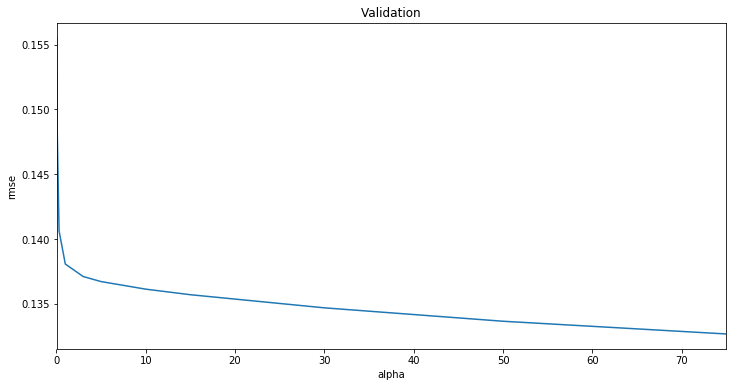

In [12]:
cv_ridge = pd.Series(cv_ridge,index = alphas)
cv_ridge.plot(title='Validation')
plt.xlabel('alpha')
plt.ylabel('rmse')

In [13]:
cv_ridge.min()

0.13266389691774666

In [ ]:
model_lasso = LassoCV(alphas = [1,0.1,0.001,0.0005])
model_lasso.fit(X_train,y)

LassoCV(alphas=[1, 0.1, 0.001, 0.0005], copy_X=True, cv='warn', eps=0.001,
    fit_intercept=True, max_iter=1000, n_alphas=100, n_jobs=None,
    normalize=False, positive=False, precompute='auto', random_state=None,
    selection='cyclic', tol=0.0001, verbose=False)

In [ ]:
rmse_cv(model_lasso).mean()

/home/arturx/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


0.12884376719006482

In [ ]:
coef = pd.Series(model_lasso.coef_,index = X_train.columns)

In [ ]:
print('Lasso picked ' + str(sum(coef!=0)) + ' variables and exterminated ' + str(sum(coef == 0)) + ' variables')

Lasso picked 195 variables and exterminated 93 variables


In [ ]:
imp_coef = pd.concat([coef.sort_values().head(10),
                     coef.sort_values().tail(10)])

Text(0.5, 1.0, 'Coefficients in linear model regularized by Lasso')

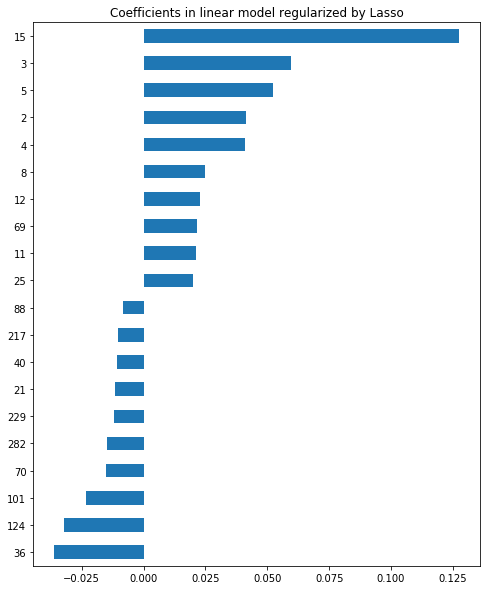

In [ ]:
matplotlib.rcParams['figure.figsize'] = (8.,10.)
imp_coef.plot(kind = 'barh')
plt.title('Coefficients in linear model regularized by Lasso')

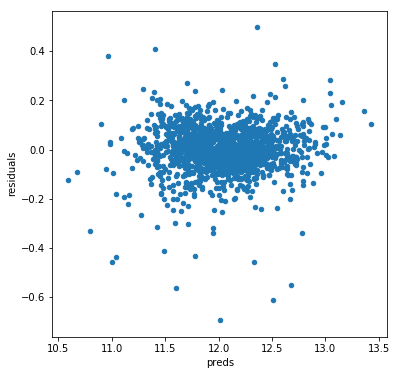

In [ ]:
matplotlib.rcParams['figure.figsize'] = (6.,6.)

preds = pd.DataFrame({'preds':model_lasso.predict(X_train),'true':y})
preds['residuals'] = preds['true'] - preds['preds']
preds.plot(x = 'preds',y = 'residuals',kind = 'scatter')

In [ ]:
ridge = Ridge(alpha = 10)
ridge.fit(X_train,y)
result = pd.DataFrame({'Id':iD,'SalePrice':np.expm1(ridge.predict(X_test))})
result.to_csv('results_linear.csv',index=False)

# XGBoosting

import xgboost as xgb

dtrain = xgb.DMatrix(X_train,label=y)
dtest = xgb.DMatrix(X_test)

params = {'max_depth':2,'eta':0.1}
# model = xgb.cv(params,dtrain,num_boost_round=500,early_stopping_rounds=100)

In [ ]:
# model.loc[30:,['test-rmse-mean','train-rmse-mean']].plot()

model_xgb = xgb.XGBRegressor(n_estimators=360,max_depth=2,learning_rate=0.1)

model_xgb.fit(X_train,y)

xgb_preds = np.expm1(model_xgb.predict(X_test))
lasso_preds = np.expm1(model_lasso.predict(X_test))

predictions = pd.DataFrame({'xgb':xgb_preds,'lasso':lasso_preds})
predictions.plot(x = 'xgb',y='lasso',kind='scatter')

In [ ]:
import tensorflow


preds = 0.8*lasso_preds + 0.2*xgb_preds
result = pd.DataFrame({'id':iD,'SalePrice':preds})
result.to_csv('lasso_xgb.csv',index = False)

In [ ]:
from tensorflow.keras.layers import Dense,BatchNormalization,Dropout
from tensorflow.keras.models import Sequential
from tensorflow.keras.regularizers import l1
from sklearn.model_selection import train_test_split

In [ ]:
X_train = StandardScaler().fit_transform(X_train)

In [ ]:
X_tr,X_val,y_tr,y_val = train_test_split(X_train,y,random_state = 42)

In [ ]:
X_tr.shape

(1095, 288)

model_nn = Sequential()
model_nn.add(Dense(1000,input_dim = X_train.shape[1],W_regularizer = l1(0.001)))
model_nn.add(Dense(500,W_regularizer=l1(0.001)))
model_nn.add(BatchNormalization())
model_nn.add(Dropout(0.3))
model_nn.add(Dense(500,W_regularizer=l1(0.001)))
model_nn.add(BatchNormalization())
model_nn.add(Dropout(0.3))
model_nn.add(Dense(500,W_regularizer=l1(0.001)))
model_nn.add(BatchNormalization())
model_nn.add(Dropout(0.3))
model_nn.add(Dense(500,W_regularizer=l1(0.001)))
model_nn.add(BatchNormalization())
model_nn.add(Dropout(0.3))
model_nn.add(Dense(1))
model_nn.compile(loss = 'mse',optimizer = 'adam')

model_nn.summary()

%%time
hist = model_nn.fit(X_tr,y_tr, validation_data = (X_val,y_val),epochs=350,verbose=0)

nn_preds = model_nn.predict(X_test)
nn_preds.resize(1459,)

In [ ]:
X_tr.shape

(1095, 288)

In [ ]:
X_tr = X_tr.reshape(X_tr.shape[0],X_tr.shape[1],1)

In [ ]:
X_val = X_val.reshape(X_val.shape[0],X_val.shape[1],1)

In [ ]:
from tensorflow.keras.layers import Conv1D,Conv2D,MaxPool1D,MaxPool2D,Flatten

In [ ]:
X_tr.shape

(1095, 288, 1)

In [ ]:
%%time
cnn = Sequential()
cnn.add(Conv1D(512,1,input_shape=(288,1)))
cnn.add(Conv1D(512,1))
cnn.add(MaxPool1D(1))
cnn.add(Conv1D(256,1))
cnn.add(Conv1D(256,1))
cnn.add(MaxPool1D(1))
cnn.add(Conv1D(128,1))
cnn.add(Conv1D(128,1))
cnn.add(Flatten())
cnn.add(Dense(500,activation='relu'))
cnn.add(BatchNormalization())
cnn.add(Dropout(0.3))
cnn.add(Dense(250,activation='relu'))
cnn.add(Dense(1))
cnn.compile(loss='mse',optimizer='adagrad')
hist_cnn = cnn.fit(X_tr,y_tr, validation_data = (X_val,y_val),epochs=1,verbose=0)

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
Instructions for updating:
Use tf.cast instead.
Instructions for updating:
Use tf.cast instead.
